## Imports & Preliminary Processing

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [3]:
# ease of viewing
pd.set_option('display.max_columns',None)
sns.set_style(style="whitegrid")

In [4]:
# Used primarily for VAR model. NO encoded counterparties
# used in train, test segments for VAR

df = pd.read_csv('../data/csv_exports/nocp_FINAL_modeling.csv')

In [5]:
# reestablish index
df['Trade date'] = pd.to_datetime(df[df.columns[0]])
df.index = df['Trade date']

In [6]:
df.head(1)

,0,Trade date,Settlement date,"Trade amount (in millions, USD)",Price,"Accrued interest (in dollars, USD)","Total amount transferred (in millions, USD)",Coupon,Term,1 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR,Time to Maturity (Years),Time to Maturity (Months),Transaction category_Sale,Type_T-Bond,Type_T-Note
Trade date,,,,,,,,,,,,,,,,,,,,,,,,,
2010-08-17,2010-08-17 00:00:00.000,2010-08-17,2010-08-18,25,104.773438,275900.14,26.46926,2.375,2015-02-28,0.16,0.17,0.19,0.26,0.52,0.78,1.44,2.06,2.64,3.47,3.77,4.533974,54.407688,0,0,1


In [7]:
# Encoded counterparty list csv for Neural Net Models
# This DataFrame is the primary focus for Neural Net Models
dfcp = pd.read_csv('../data/csv_exports/FINAL_modeling.csv')

In [8]:
dfcp.head(1)

,0,Trade date,Settlement date,"Trade amount (in millions, USD)",Price,"Accrued interest (in dollars, USD)","Total amount transferred (in millions, USD)",Coupon,Term,1 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR,Time to Maturity (Years),Time to Maturity (Months),Transaction category_Sale,Type_T-Bond,Type_T-Note,Counterparty_BNP Paribas Securities Corp.,Counterparty_Banc of America Securities LLC,"Counterparty_Bank of Nova Scotia, New York Agency",Counterparty_Barclays Capital Inc.,"Counterparty_Cabrera Capital Markets, LLC",Counterparty_Cantor Fitzgerald & Co.,Counterparty_Citigroup Global Markets Inc.,Counterparty_Credit Suisse Securities (USA) LLC,Counterparty_Daiwa Capital Markets America Inc.,Counterparty_Deutsche Bank Securities Inc.,Counterparty_G.X. Clarke & Co.,"Counterparty_Goldman, Sachs & Co.",Counterparty_HSBC Securities (USA) Inc.,Counterparty_J.P. Morgan Securities LLC,"Counterparty_Jefferies & Company, Inc.",Counterparty_Loop Capital Markets LLC,Counterparty_MF Global Inc.,"Counterparty_Merrill Lynch, Pierce, Fenner & Smith Incorporated","Counterparty_Mischler Financial Group, Inc.",Counterparty_Mizuho Securities USA Inc.,Counterparty_Morgan Stanley & Co. LLC,"Counterparty_Nomura Securities International, Inc.","Counterparty_RBC Capital Markets, LLC",Counterparty_RBS Securities Inc.,"Counterparty_SG Americas Securities, LLC",Counterparty_TD Securities (USA) LLC,Counterparty_UBS Securities LLC
0,2010-08-17 00:00:00.000,2010-08-17,2010-08-18,25,104.773438,275900.14,26.46926,2.375,2015-02-28,0.16,0.17,0.19,0.26,0.52,0.78,1.44,2.06,2.64,3.47,3.77,4.533974,54.407688,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# reset index
dfcp['Trade date'] = pd.to_datetime(dfcp[dfcp.columns[0]])
dfcp.index = dfcp['Trade date']

### Augmented Dicky Fuller Tests: Predictors & Targets Tested

In [10]:
# Code written by Joseph Nelson.
# Improved by Hovanes Gasparian

# DF Tests to check stationarity for all relevant features df or dfcp can to be used
# dfcp only has additional encoded features for counterparties. Tests done on df

# p-value threshold is .05 for passing for our purposes.

# Interest Rate Maturities 1 year and beyond were all found to not be stationary
# This is not a surprise as they are the most time dependent of all features here
# Interest rates shorter than 1 year were stationary

# First differencing was applied
# No feature required more than 1 Difference oeration

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

In [11]:
interpret_dftest(adfuller(dfcp['Price']))
# stationary = < .05 for DF Test
# stationary

Test Statistic   -22.554195
p-value            0.000000
Lag Used          24.000000
dtype: float64

In [12]:
interpret_dftest(adfuller(dfcp['Accrued interest (in dollars, USD)']))
# stationary

Test Statistic   -29.21764
p-value            0.00000
Lag Used          61.00000
dtype: float64

In [13]:
interpret_dftest(adfuller(dfcp['Total amount transferred (in millions, USD)']))
# stationary

Test Statistic   -29.123444
p-value            0.000000
Lag Used          59.000000
dtype: float64

In [14]:
interpret_dftest(adfuller(dfcp['Coupon']))
# stationary

Test Statistic   -24.254282
p-value            0.000000
Lag Used          62.000000
dtype: float64

In [15]:
interpret_dftest(adfuller(dfcp['Time to Maturity (Months)']))
# stationary

Test Statistic   -23.946097
p-value            0.000000
Lag Used          63.000000
dtype: float64

In [16]:
interpret_dftest(adfuller(dfcp['Time to Maturity (Years)']))
# stationary

Test Statistic   -23.946097
p-value            0.000000
Lag Used          63.000000
dtype: float64

In [17]:
interpret_dftest(adfuller(df['1 MO']))
# stationary

Test Statistic   -6.117947e+00
p-value           8.999224e-08
Lag Used          4.800000e+01
dtype: float64

In [18]:
interpret_dftest(adfuller(df['3 MO']))
# stationary

Test Statistic    -4.021921
p-value            0.001300
Lag Used          62.000000
dtype: float64

In [19]:
interpret_dftest(adfuller(dfcp['6 MO']))
# not stationary

Test Statistic    -3.148279
p-value            0.023181
Lag Used          57.000000
dtype: float64

In [20]:
interpret_dftest(adfuller(df['1 YR']))
# not stationary

Test Statistic    -2.918362
p-value            0.043254
Lag Used          52.000000
dtype: float64

In [21]:
interpret_dftest(adfuller(df['1 YR'].diff(1).dropna()))
# stationary

Test Statistic   -41.694634
p-value            0.000000
Lag Used          51.000000
dtype: float64

In [22]:
interpret_dftest(adfuller(df['2 YR']))
# not stationary

Test Statistic   -2.752579
p-value           0.065373
Lag Used          0.000000
dtype: float64

In [23]:
interpret_dftest(adfuller(df['2 YR'].diff(1).dropna()))
# stationary

Test Statistic   -284.436359
p-value             0.000000
Lag Used            0.000000
dtype: float64

In [24]:
interpret_dftest(adfuller(df['3 YR']))
# not stationary

Test Statistic   -1.944211
p-value           0.311557
Lag Used          0.000000
dtype: float64

In [25]:
interpret_dftest(adfuller(df['3 YR'].diff(1).dropna()))
# stationary

Test Statistic   -284.436287
p-value             0.000000
Lag Used            0.000000
dtype: float64

In [26]:
interpret_dftest(adfuller(df['7 YR']))
# not stationary

Test Statistic   -1.522535
p-value           0.522335
Lag Used          0.000000
dtype: float64

In [27]:
interpret_dftest(adfuller(df['7 YR'].diff(1).dropna()))
# stationary

Test Statistic   -284.436301
p-value             0.000000
Lag Used            0.000000
dtype: float64

In [28]:
interpret_dftest(adfuller(df['5 YR']))
# not stationary

Test Statistic   -1.537765
p-value           0.514754
Lag Used          0.000000
dtype: float64

In [29]:
interpret_dftest(adfuller(df['5 YR'].diff(1).dropna()))
# stationary

Test Statistic   -284.436292
p-value             0.000000
Lag Used            0.000000
dtype: float64

In [30]:
interpret_dftest(adfuller(df['10 YR']))
# not stationary

Test Statistic    -1.509802
p-value            0.528657
Lag Used          58.000000
dtype: float64

In [31]:
interpret_dftest(adfuller(df['10 YR'].diff(1).dropna()))
# stationary

Test Statistic   -37.201357
p-value            0.000000
Lag Used          57.000000
dtype: float64

In [32]:
interpret_dftest(adfuller(df['20 YR']))
# not stationary

Test Statistic    -1.402177
p-value            0.581232
Lag Used          58.000000
dtype: float64

In [33]:
interpret_dftest(adfuller(df['20 YR'].diff(1).dropna()))
# stationary

Test Statistic   -38.041707
p-value            0.000000
Lag Used          57.000000
dtype: float64

In [34]:
interpret_dftest(adfuller(df['30 YR']))
# not stationary

Test Statistic    -1.457577
p-value            0.554383
Lag Used          58.000000
dtype: float64

In [35]:
interpret_dftest(adfuller(df['30 YR'].diff(1).dropna()))
# stationary

Test Statistic   -38.476322
p-value            0.000000
Lag Used          57.000000
dtype: float64

In [36]:
# test = pd.DataFrame(Xs_train)

# interpret_dftest(adfuller(test[test.columns[3]]))
# # stationary

In [37]:
# engineer percentage changes for stationarity in feature selection
# this procedure was abandoned

# dfcp['1YR_pct_change'] = dfcp['1 YR'].pct_change().fillna(dfcp['1 YR'][0])
# dfcp['2YR_pct_change'] = dfcp['2 YR'].pct_change().fillna(dfcp['2 YR'][0])
# dfcp['3YR_pct_change'] = dfcp['3 YR'].pct_change().fillna(dfcp['3 YR'][0])
# dfcp['5YR_pct_change'] = dfcp['5 YR'].pct_change().fillna(dfcp['5 YR'][0])
# dfcp['7YR_pct_change'] = dfcp['7 YR'].pct_change().fillna(dfcp['7 YR'][0])
# dfcp['10YR_pct_change'] = dfcp['10 YR'].pct_change().fillna(dfcp['10 YR'][0])
# dfcp['20YR_pct_change'] = dfcp['20 YR'].pct_change().fillna(dfcp['20 YR'][0])
# dfcp['30YR_pct_change'] = dfcp['30 YR'].pct_change().fillna(dfcp['30 YR'][0])

### Feature Selection & Time Series TTS

In [192]:
# Toggle here for feature selection
# Priority is given to DataFrame with encoded counterparties for Neural Nets

# These columns are redundant to other features 
drop_cols = [df.columns[0],'Counterparty','Settlement date','Trade date',
             'Trade amount (in millions, USD)','Term','Date']

# these features are not stationary
term_cols = ['1 MO','3 MO','6 MO','1 YR','2 YR','3 YR','5 YR','7 YR','10 YR','20 YR','30 YR']

# toggle this string value based on list of term cols
target = '30 YR'

# Target is identified after the != operator. This can be toggled for different interest rate targets.
features = [col for col in dfcp.columns if col != target and col not in drop_cols]

# Create feature Matrices
# Toggle for models with just yield curve

# X array for just yield curve modeling
# X = dfcp[col for col in term_cols if col != '10 YR']

X = dfcp[features]
y = dfcp[target]

# target is not differenced here as it is not lagged with the Neural Net

# target itself does not need to be stationary as it is not lagged here?
# https://stackoverflow.com/questions/29765548/remove-index-name-in-pandas
X.index.name = None

In [193]:
len(X)

80908

In [194]:
len(y)

80908

In [195]:
# display baseline prediction value
# Whole number percentage as interest rate
y.mean()

3.400959608444341

In [196]:
# verify selected features
X.head(4)

,Price,"Accrued interest (in dollars, USD)","Total amount transferred (in millions, USD)",Coupon,1 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,Time to Maturity (Years),Time to Maturity (Months),Transaction category_Sale,Type_T-Bond,Type_T-Note,Counterparty_BNP Paribas Securities Corp.,Counterparty_Banc of America Securities LLC,"Counterparty_Bank of Nova Scotia, New York Agency",Counterparty_Barclays Capital Inc.,"Counterparty_Cabrera Capital Markets, LLC",Counterparty_Cantor Fitzgerald & Co.,Counterparty_Citigroup Global Markets Inc.,Counterparty_Credit Suisse Securities (USA) LLC,Counterparty_Daiwa Capital Markets America Inc.,Counterparty_Deutsche Bank Securities Inc.,Counterparty_G.X. Clarke & Co.,"Counterparty_Goldman, Sachs & Co.",Counterparty_HSBC Securities (USA) Inc.,Counterparty_J.P. Morgan Securities LLC,"Counterparty_Jefferies & Company, Inc.",Counterparty_Loop Capital Markets LLC,Counterparty_MF Global Inc.,"Counterparty_Merrill Lynch, Pierce, Fenner & Smith Incorporated","Counterparty_Mischler Financial Group, Inc.",Counterparty_Mizuho Securities USA Inc.,Counterparty_Morgan Stanley & Co. LLC,"Counterparty_Nomura Securities International, Inc.","Counterparty_RBC Capital Markets, LLC",Counterparty_RBS Securities Inc.,"Counterparty_SG Americas Securities, LLC",Counterparty_TD Securities (USA) LLC,Counterparty_UBS Securities LLC
2010-08-17 00:00:00.000,104.773438,275900.14,26.469260,2.375,0.16,0.17,0.19,0.26,0.52,0.78,1.44,2.06,2.64,3.47,4.533974,54.407688,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-08-17 00:27:17.070,104.921875,354959.24,52.815897,2.375,0.16,0.17,0.19,0.26,0.52,0.78,1.44,2.06,2.64,3.47,4.205425,50.465102,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-08-17 00:54:34.140,104.968750,110360.05,10.607235,2.375,0.16,0.17,0.19,0.26,0.52,0.78,1.44,2.06,2.64,3.47,4.038413,48.460954,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-08-17 01:21:51.210,105.937500,174762.23,53.143512,2.625,0.16,0.17,0.19,0.26,0.52,0.78,1.44,2.06,2.64,3.47,4.372437,52.469250,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [197]:
# TTS
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,train_size=.5)

In [198]:
# Verify chronology sequence for Train and Test values
X_train.index.max()

Timestamp('2012-09-21 11:39:52.710000')

In [199]:
X_test.index.min()

Timestamp('2012-09-21 12:07:09.780000')

In [200]:
X_test.index.max()

Timestamp('2014-10-27 23:47:02.490000')

In [201]:
# StandardScaler cannot accept pd.datetime datatypes
# We beleive partner interest rate predictor features at other past points on the yield curve 
# become stationary with this transformation.

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [202]:
# Neural Net Scaffolding
# Time Series generator used for convenience for training
# length selected is 53m as it approximates previous rows that equal 1 previous day
# essentailly we are looking back 1 day to predict value at the next half hour approximately

# 53 is selected as it is approximate number of rows for looking back 1 day (each row just under 1 half hour)
lookback = 53

train_sequences = TimeseriesGenerator(Xs_train,y_train,length=lookback,batch_size=64)
test_sequences = TimeseriesGenerator(Xs_test,y_test,length=lookback,batch_size=64)
input_shape = train_sequences[0][0][0].shape

In [203]:
train_sequences[0][0].shape

(64, 53, 46)

In [204]:
input_shape

(53, 46)

In [205]:
X_train.shape

(40454, 46)

### Models: Neural Nets

In [206]:
# RNN

# 15 epochs: long runtime due to 53 row length from Time Series Generator
# Simpler architecture with no regularization
# MAPE identified as meaningul metric for comparisons
# MSE considered as well

rnn = Sequential()
rnn.add(GRU(16, input_shape=input_shape, return_sequences=True))
rnn.add(GRU(8, return_sequences=False))
# leave default activation for GRUs

rnn.add(Dense(4, activation='relu'))

rnn.add(Dense(1, activation='linear'))

In [207]:
rnn.compile(optimizer='adam', loss='mape',metrics=['mse'])

history = rnn.fit(train_sequences, validation_data=test_sequences, epochs=15,batch_size=64)

Epoch 1/15
632/632 [==============================] - 24s 38ms/step - loss: 29.1045 - mse: 3.6290 - val_loss: 8.7565 - val_mse: 0.1067
Epoch 2/15
632/632 [==============================] - 21s 33ms/step - loss: 3.1141 - mse: 0.0186 - val_loss: 6.4047 - val_mse: 0.0828
Epoch 3/15
632/632 [==============================] - 21s 33ms/step - loss: 2.2138 - mse: 0.0096 - val_loss: 4.7575 - val_mse: 0.0461
Epoch 4/15
632/632 [==============================] - 20s 32ms/step - loss: 1.9248 - mse: 0.0074 - val_loss: 4.5908 - val_mse: 0.0424
Epoch 5/15
632/632 [==============================] - 20s 32ms/step - loss: 1.7623 - mse: 0.0059 - val_loss: 4.1143 - val_mse: 0.0344
Epoch 6/15
632/632 [==============================] - 20s 32ms/step - loss: 1.6690 - mse: 0.0054 - val_loss: 4.1259 - val_mse: 0.0222
Epoch 7/15
632/632 [==============================] - 20s 32ms/step - loss: 1.5040 - mse: 0.0043 - val_loss: 2.9218 - val_mse: 0.0149
Epoch 8/15
632/632 [==============================] - 20s 32m

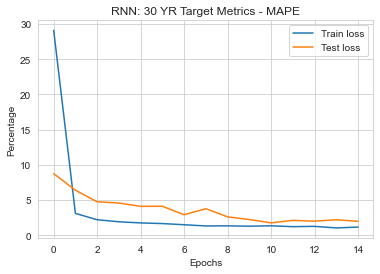

In [208]:
# MAPE Evaluation

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title(f'RNN: {target} Target Metrics - MAPE')
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.legend();

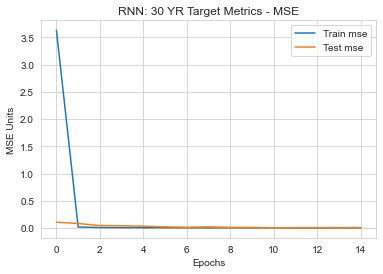

In [209]:
# MSE Evaluation

plt.plot(history.history['mse'], label='Train mse')
plt.plot(history.history['val_mse'], label='Test mse')
plt.title(f'RNN: {target} Target Metrics - MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE Units')
plt.legend();

## RNN with Dropout

In [234]:
# Dropout selected over early stopping or Lasso & Ridge

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

rnn2 = Sequential()
rnn2.add(GRU(16, input_shape=input_shape, return_sequences=True))
rnn2.add(GRU(8, return_sequences=False))

# leave default activation layer for GRUs
rnn2.add(Dense(4, activation='relu'))
rnn2.add(Dropout(0.2))

rnn2.add(Dense(1, activation='linear'))

rnn2.compile(optimizer='adam', loss='mape', metrics=['mse'])

history2 = rnn2.fit(train_sequences, validation_data=test_sequences, epochs=15, batch_size = 64)

Epoch 1/15
632/632 [==============================] - 21s 33ms/step - loss: 43.8823 - mse: 4.3987 - val_loss: 15.3284 - val_mse: 0.2699
Epoch 2/15
632/632 [==============================] - 20s 32ms/step - loss: 18.9508 - mse: 1.3406 - val_loss: 13.4360 - val_mse: 0.2059
Epoch 3/15
632/632 [==============================] - 20s 32ms/step - loss: 17.5104 - mse: 1.2107 - val_loss: 14.6310 - val_mse: 0.2327
Epoch 4/15
632/632 [==============================] - 20s 32ms/step - loss: 16.1641 - mse: 1.0530 - val_loss: 13.7772 - val_mse: 0.2054
Epoch 5/15
632/632 [==============================] - 20s 32ms/step - loss: 14.7246 - mse: 0.9069 - val_loss: 12.6674 - val_mse: 0.1730
Epoch 6/15
632/632 [==============================] - 20s 32ms/step - loss: 13.4001 - mse: 0.7694 - val_loss: 10.7444 - val_mse: 0.1260
Epoch 7/15
632/632 [==============================] - 20s 32ms/step - loss: 12.1789 - mse: 0.6505 - val_loss: 9.0821 - val_mse: 0.0962
Epoch 8/15
632/632 [=============================

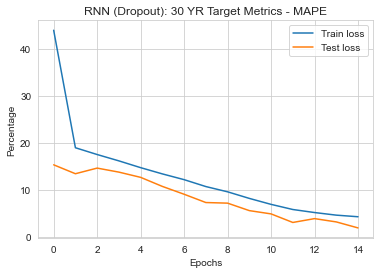

In [235]:
# MAPE evaluation

plt.plot(history2.history['loss'], label='Train loss')
plt.plot(history2.history['val_loss'], label='Test loss')
plt.title(f'RNN (Dropout): {target} Target Metrics - MAPE')
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.legend();

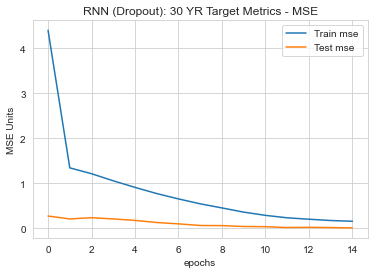

In [236]:
# MSE Evaluation

plt.plot(history2.history['mse'], label='Train mse')
plt.plot(history2.history['val_mse'], label='Test mse')
plt.title(f'RNN (Dropout): {target} Target Metrics - MSE')
plt.xlabel('epochs')
plt.ylabel('MSE Units')
plt.legend();

## LSTM:

In [213]:
# Experimental
# LSTM seems to be more sensitive by epoch with MAPE
# Tuning experiments need to be done with Memory saving at each layer

lstm = Sequential()
lstm.add(LSTM(units=50,input_shape=input_shape,return_sequences=True))
lstm.add(LSTM(units=50,return_sequences=False))

lstm.add(Dense(units=32))
lstm.add(Dense(units=16))
lstm.add(Dense(units=8))

# lstm.add(Dropout(0.5))

lstm.add(Dense(units=1,activation='linear'))

lstm.compile(optimizer='adam',loss='mape',metrics=['mse'])

In [214]:
history3 = lstm.fit(train_sequences,validation_data=test_sequences,epochs=15)

Epoch 1/15
632/632 [==============================] - 26s 42ms/step - loss: 10.0792 - mse: 0.6620 - val_loss: 5.5836 - val_mse: 0.0559
Epoch 2/15
632/632 [==============================] - 25s 40ms/step - loss: 4.0534 - mse: 0.0329 - val_loss: 4.8568 - val_mse: 0.0521
Epoch 3/15
632/632 [==============================] - 25s 40ms/step - loss: 3.0660 - mse: 0.0189 - val_loss: 4.9236 - val_mse: 0.0459
Epoch 4/15
632/632 [==============================] - 25s 39ms/step - loss: 2.9230 - mse: 0.0177 - val_loss: 4.0817 - val_mse: 0.0355
Epoch 5/15
632/632 [==============================] - 25s 40ms/step - loss: 2.5169 - mse: 0.0128 - val_loss: 6.2169 - val_mse: 0.0764
Epoch 6/15
632/632 [==============================] - 25s 39ms/step - loss: 2.2711 - mse: 0.0103 - val_loss: 2.9495 - val_mse: 0.0323
Epoch 7/15
632/632 [==============================] - 25s 39ms/step - loss: 2.1137 - mse: 0.0089 - val_loss: 3.3614 - val_mse: 0.1182
Epoch 8/15
632/632 [==============================] - 25s 40m

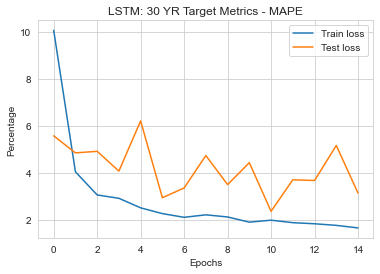

In [215]:
# MAPE Evaluation

# PLEASE NOTE: The scale of the y-axis as errors may be significant for shorter dated interest rates.

plt.plot(history3.history['loss'], label='Train loss')
plt.plot(history3.history['val_loss'], label='Test loss')
plt.title(f'LSTM: {target} Target Metrics - MAPE')
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.legend();

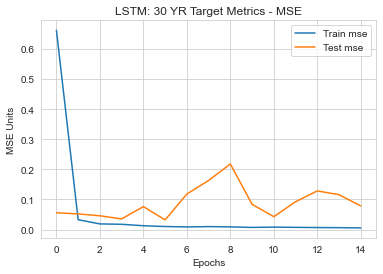

In [216]:
# MSE Evaluation

plt.plot(history3.history['mse'], label='Train mse')
plt.plot(history3.history['val_mse'], label='Test mse')
plt.title(f'LSTM: {target} Target Metrics - MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE Units')
plt.legend();

In [217]:
rnn_preds = rnn.predict(test_sequences)
rnn2_preds = rnn2.predict(test_sequences)
lstm_preds = lstm.predict(test_sequences)

### Neural Net Summaries

In [218]:
rnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 53, 16)            3072      
_________________________________________________________________
gru_11 (GRU)                 (None, 8)                 624       
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 5         
Total params: 3,737
Trainable params: 3,737
Non-trainable params: 0
_________________________________________________________________


In [219]:
rnn2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 53, 16)            3072      
_________________________________________________________________
gru_13 (GRU)                 (None, 8)                 624       
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 5         
Total params: 3,737
Trainable params: 3,737
Non-trainable params: 0
_________________________________________________________________


In [220]:
lstm.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 53, 50)            19400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 41,905
Trainable params: 41,905
Non-trainable params: 0
_________________________________________________

### Further Comparison of Standalone Metrics:

In [221]:
# https://stackoverflow.com/questions/57002948/how-to-calculate-mean-absolute-percentage-error-for-regression-probem-in-python
# Origin of Function solution

# verifying MAPE from model output and for comparison with VAR Model

# Credit to Dan Wilhelm for solution to infinite error problem

def mean_absolute_percentage_error(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indexes = np.where(y_true != 0)
    y_true, y_pred = y_true[nonzero_indexes], y_pred[nonzero_indexes]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [222]:
len(y_test[lookback:])

40401

In [223]:
len(rnn_preds)

40401

In [224]:
print(f'{target} RNN: RMSE')
mean_squared_error(y_test[lookback:],rnn_preds)**.5

30 YR RNN: RMSE


0.0834028079451892

In [225]:
print(f'{target} RNN (Dropout): RMSE')
mean_squared_error(y_test[lookback:],rnn2_preds)**.5

30 YR RNN (Dropout): RMSE


0.14106849728754117

In [226]:
print(f'{target} LSTM: RMSE')
mean_squared_error(y_test[lookback:],lstm_preds)**.5

30 YR LSTM: RMSE


0.28030585129778907

In [227]:
print(f'{target} RNN: MAPE')
mean_absolute_percentage_error(y_test[lookback:],rnn_preds)

30 YR RNN: MAPE


14.312015836685186

In [228]:
print(f'{target} RNN (Dropout): MAPE')
mean_absolute_percentage_error(y_test[lookback:],rnn2_preds)

30 YR RNN (Dropout): MAPE


11.908068552309196

In [229]:
print(f'{target} LSTM: MAPE')
mean_absolute_percentage_error(y_test[lookback:],lstm_preds)

30 YR LSTM: MAPE


15.356896042993398

### Visual Evaluation of Neural Net Predictions

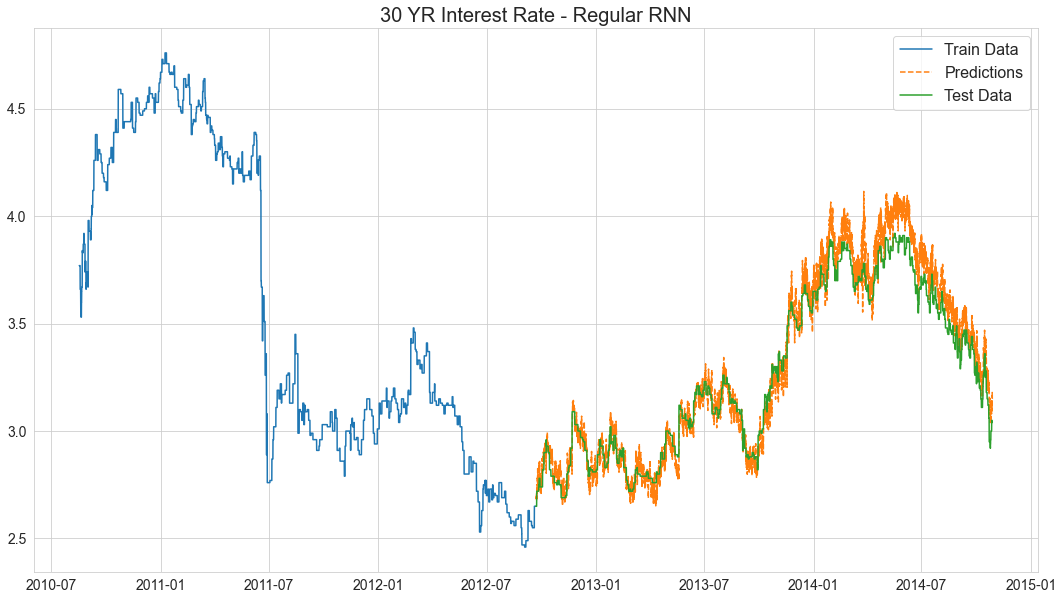

In [230]:
# RNN

# Observation that longer dated maturities for interest rates had more accuracy than shorter ones
# Question of Stationarity in features
# 53 previous row window is predicting 1 single following row as a possible explanation

rnn_preds = pd.DataFrame(rnn_preds)
rnn_preds.index = y_test[lookback:].index

plt.figure(figsize=(18,10))
plt.plot(y_train)
# plt.plot(train_preds,linestyle='dashed')
plt.plot(rnn_preds,linestyle='dashed')
# toggle title with target
plt.title(f'{target} Interest Rate - Regular RNN',size=20)
plt.plot(y_test)
plt.legend(['Train Data','Predictions','Test Data'],prop={'size':16})
plt.xticks(size=14)
# plt.ylim(-0.15,0.5)
plt.yticks(size=14);

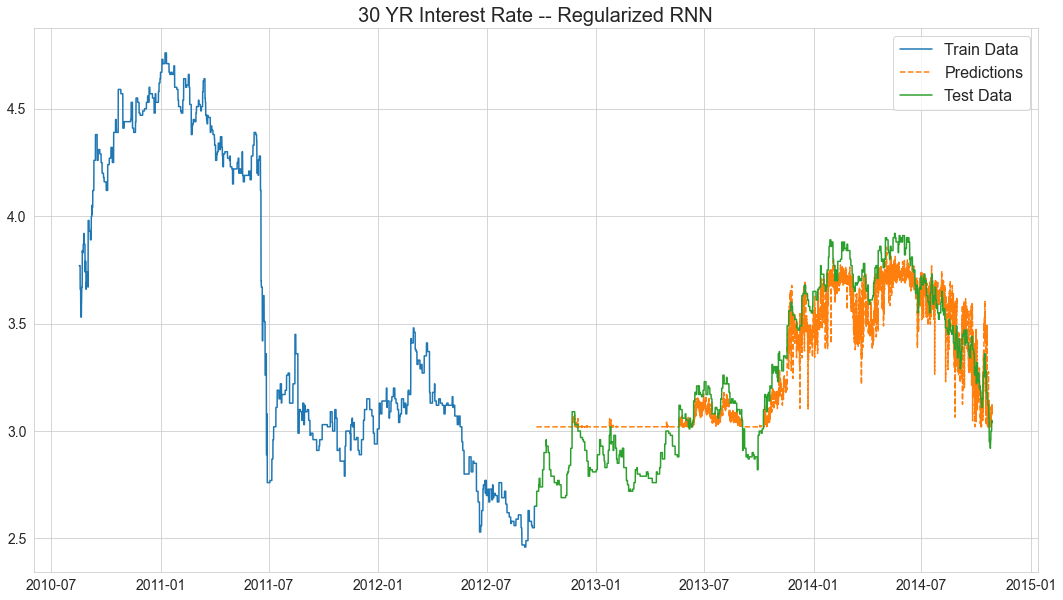

In [237]:
# RNN with Regularization

rnn2_preds = pd.DataFrame(rnn2_preds)
rnn2_preds.index = y_test[lookback:].index

plt.figure(figsize=(18,10))
plt.plot(y_train)
# plt.plot(train_preds,linestyle='dashed')
plt.plot(rnn2_preds,linestyle='dashed')
plt.title(f'{target} Interest Rate -- Regularized RNN',size=20)
plt.plot(y_test)
plt.legend(['Train Data','Predictions','Test Data'],prop={'size':16})
plt.xticks(size=14)
plt.yticks(size=14);

In [232]:
y.mean()

3.400959608444341

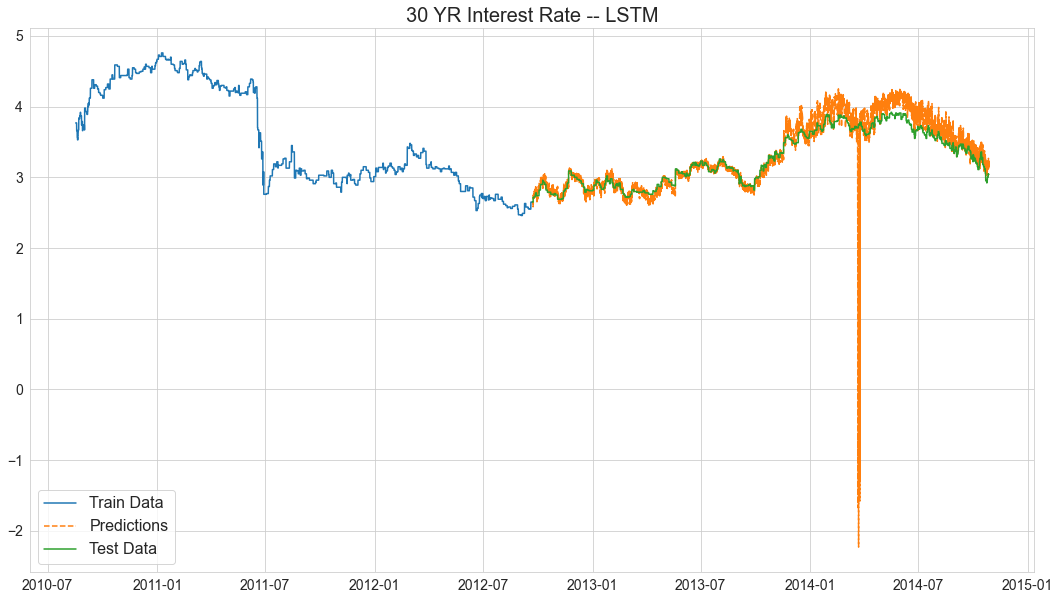

In [233]:
# LSTM

lstm_preds = pd.DataFrame(lstm_preds)
lstm_preds.index = y_test[lookback:].index

plt.figure(figsize=(18,10))
plt.plot(y_train)
# plt.plot(train_preds,linestyle='dashed')
plt.plot(lstm_preds,linestyle='dashed')
plt.title(f'{target} Interest Rate -- LSTM',size=20)
plt.plot(y_test)
plt.legend(['Train Data','Predictions','Test Data'],prop={'size':16})
plt.xticks(size=14)
plt.yticks(size=14);

## Models: VAR

In [160]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

### First Differencing for Stationarity of Multivariate Targets:

In [161]:
# Create new dataFrame for VAR model

dfvar = df[['3 MO']].copy()
dfvar.index = df.index

In [162]:
# Differenced features for VAR DataFrame

dfvar['30YR_first_diff'] = df['30 YR'].diff(1).copy()
dfvar['20YR_first_diff'] = df['20 YR'].diff(1).copy()
dfvar['10YR_first_diff'] = df['10 YR'].diff(1).copy()
dfvar['5YR_first_diff'] = df['5 YR'].diff(1).copy()
dfvar['1YR_first_diff'] = df['1 YR'].diff(1).copy()
dfvar['6 MO'] = df['6 MO'].copy()
dfvar['1 MO'] = df['1 MO'].copy()

In [163]:
dfvar.columns

Index(['3 MO', '30YR_first_diff', '20YR_first_diff', '10YR_first_diff',
       '5YR_first_diff', '1YR_first_diff', '6 MO', '1 MO'],
      dtype='object')

In [164]:
# Organize VAR DataFrame & TTS

dfvar = dfvar[['1 MO','3 MO','6 MO','1YR_first_diff','5YR_first_diff',
               '10YR_first_diff','20YR_first_diff','30YR_first_diff']]

train, test = train_test_split(dfvar.dropna(),
                               test_size = 0.25,
                               shuffle = False)

In [165]:
# Instantiate VAR Model
modelvar = VAR(train)

/Users/ash/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 1637070L will be used.
  % freq, ValueWarning)


In [166]:
# maxlags for max value of p
tsvar = modelvar.fit(maxlags=15,ic='aic')

In [167]:
# optimal p value for aic
tsvar.k_ar

1

In [168]:
tsvar.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Dec, 2020
Time:                     22:45:13
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -104.118
Nobs:                     60679.0    HQIC:                  -104.126
Log likelihood:       2.47050e+06    FPE:                5.98847e-46
AIC:                     -104.129    Det(Omega_mle):     5.98137e-46
--------------------------------------------------------------------
Results for equation 1 MO
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.000018         0.000026            0.712           0.476
L1.1 MO                    0.997793         0.000301         3317.047           0.000
L1.3 MO                    0.002168      

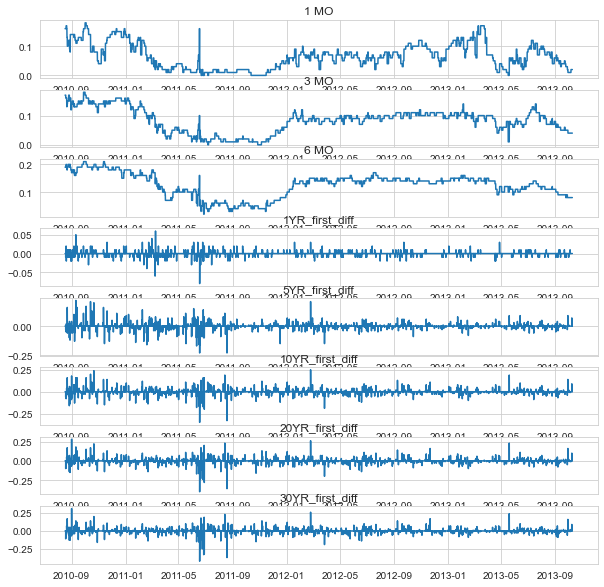

In [169]:
tsvar.plot();

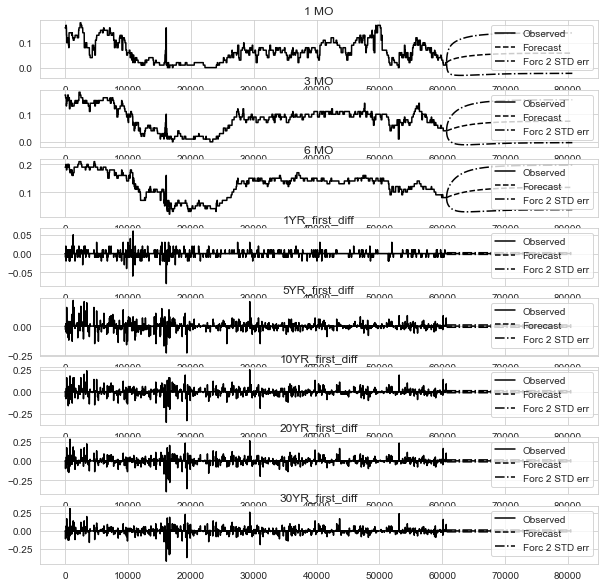

In [170]:
tsvar.plot_forecast(20_000);

## VAR Forecasting & Metrics

In [171]:
# original forecast for MSE calculation
# MAPE & MSE evaluated for comparisons

forecast_var = tsvar.forecast(train.values,len(test))

In [172]:
# array length verification
len(train)

60680

In [173]:
len(test)

20227

In [174]:
# Credit to Dan Wilhelm for demonstration
# Initial Scores difficult to interpret

for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {mean_squared_error(test.values[:, i], forecast_var[:, i])}')

The test MSE on the 1 MO data is: 0.0017889652291834444
The test MSE on the 3 MO data is: 0.0011162540236494686
The test MSE on the 6 MO data is: 0.00204819958745862
The test MSE on the 1YR_first_diff data is: 1.1469767798849954e-06
The test MSE on the 5YR_first_diff data is: 3.711581301506832e-05
The test MSE on the 10YR_first_diff data is: 3.566213203376214e-05
The test MSE on the 20YR_first_diff data is: 3.139997170398333e-05
The test MSE on the 30YR_first_diff data is: 2.8032637545667445e-05


In [175]:
# OLS based VAR struggles with respect to MAPE metrics

for i in range(test.shape[1]):
    print(f'The test MAPE on the {test.columns[i]} data is: {mean_absolute_percentage_error(test.values[:, i], forecast_var[:, i])}')

The test MAPE on the 1 MO data is: 150.9833873512377
The test MAPE on the 3 MO data is: 105.53362835008022
The test MAPE on the 6 MO data is: 70.15407716408868
The test MAPE on the 1YR_first_diff data is: 99.99910775196238
The test MAPE on the 5YR_first_diff data is: 99.99479099181926
The test MAPE on the 10YR_first_diff data is: 99.99244557711559
The test MAPE on the 20YR_first_diff data is: 99.99606282754442
The test MAPE on the 30YR_first_diff data is: 99.99196692898946


In [176]:
# Reverse Differencing and Forecasting for rfange of test data portion

forecast_var_test = tsvar.forecast(test.values,len(test))

forecastvartest_df = pd.DataFrame(forecast_var_test,columns=dfvar.columns)
forecastvartest_df.index = df.iloc[len(train)+1:].index

# Add back first row
row1test = df[['1 MO','3 MO','6 MO','1 YR','5 YR','10 YR','20 YR','30 YR']].iloc[len(train)]
row1test = pd.DataFrame(row1test).T

forecastvar_dftest1 = pd.concat([row1test,forecastvartest_df])
forecastvar_dftest1.drop(columns=['1 YR','5 YR','10 YR','20 YR','30 YR'],inplace=True)

forecastvar_dftest1['1YR_first_diff'].fillna(0.11,inplace=True)
forecastvar_dftest1['5YR_first_diff'].fillna(0.82,inplace=True)
forecastvar_dftest1['10YR_first_diff'].fillna(1.9,inplace=True)
forecastvar_dftest1['20YR_first_diff'].fillna(2.7,inplace=True)
forecastvar_dftest1['30YR_first_diff'].fillna(3.1,inplace=True)

# cumsum method used for reversal of differences
forecastvar_dftest1['1MO_forecast'] = forecastvar_dftest1['1 MO'].cumsum()
forecastvar_dftest1['3MO_forecast'] = forecastvar_dftest1['3 MO'].cumsum()
forecastvar_dftest1['6MO_forecast'] = forecastvar_dftest1['6 MO'].cumsum()
forecastvar_dftest1['1YR_forecast'] = forecastvar_dftest1['1YR_first_diff'].cumsum()
forecastvar_dftest1['5YR_forecast'] = forecastvar_dftest1['5YR_first_diff'].cumsum()
forecastvar_dftest1['10YR_forecast'] = forecastvar_dftest1['10YR_first_diff'].cumsum()
forecastvar_dftest1['20YR_forecast'] = forecastvar_dftest1['20YR_first_diff'].cumsum()
forecastvar_dftest1['30YR_forecast'] = forecastvar_dftest1['30YR_first_diff'].cumsum()

In [177]:
forecastvar_dftest1.head()

,1 MO,3 MO,6 MO,1YR_first_diff,5YR_first_diff,10YR_first_diff,20YR_first_diff,30YR_first_diff,1MO_forecast,3MO_forecast,6MO_forecast,1YR_forecast,5YR_forecast,10YR_forecast,20YR_forecast,30YR_forecast
2013-10-09 17:43:27.600,0.020000,0.040000,0.080000,0.110000,0.82000,1.900000,2.700000,3.100000,0.020000,0.040000,0.080000,0.110000,0.820000,1.900000,2.700000,3.100000
2013-10-09 18:10:44.670,0.029969,0.020024,0.060006,-0.000006,-0.00006,-0.000066,-0.000071,-0.000063,0.049969,0.060024,0.140006,0.109994,0.819940,1.899934,2.699929,3.099937
2013-10-09 18:38:01.740,0.029937,0.020048,0.060011,-0.000006,-0.00006,-0.000066,-0.000071,-0.000063,0.079906,0.080073,0.200017,0.109988,0.819879,1.899868,2.699858,3.099875
2013-10-09 19:05:18.810,0.029906,0.020073,0.060017,-0.000006,-0.00006,-0.000066,-0.000071,-0.000062,0.109812,0.100145,0.260033,0.109982,0.819819,1.899802,2.699787,3.099812
2013-10-09 19:32:35.880,0.029875,0.020097,0.060022,-0.000006,-0.00006,-0.000066,-0.000071,-0.000062,0.139687,0.120242,0.320056,0.109977,0.819759,1.899737,2.699716,3.099750


In [178]:
# reverse diffrence each forecasted feature
# adapted from:
# https://stackoverflow.com/questions/62500493/unable-to-reverse-the-first-difference-in-pandas-dataframe
# https://stackoverflow.com/questions/43408621/add-a-row-at-top-in-pandas-dataframe

# Full length of Dataset forecasts


# forecast entire length of data for plotting: First row is removed
forecast_var2 = tsvar.forecast(train.values,len(dfvar)-1)

# DataFrame for forecasting length of all data: First row is removed
forecastvar_df = pd.DataFrame(forecast_var2,columns=dfvar.columns)
forecastvar_df.index = df.index[1:]

# add back first ros
row1train = df[['1 MO','3 MO','6 MO','1 YR','5 YR','10 YR','20 YR','30 YR']].iloc[0]
row1train = pd.DataFrame(row1train).T

forecastvar_df1 = pd.concat([row1train,forecastvar_df])
forecastvar_df1.drop(columns=['1 YR','5 YR','10 YR','20 YR','30 YR'],inplace=True)

forecastvar_df1['1YR_first_diff'].fillna(0.26,inplace=True)
forecastvar_df1['5YR_first_diff'].fillna(1.44,inplace=True)
forecastvar_df1['10YR_first_diff'].fillna(2.64,inplace=True)
forecastvar_df1['20YR_first_diff'].fillna(3.47,inplace=True)
forecastvar_df1['30YR_first_diff'].fillna(3.77,inplace=True)

forecastvar_df = forecastvar_df1.copy()

# cumsum for reversing differences
forecastvar_df['1MO_forecast'] = forecastvar_df['1 MO'].cumsum()
forecastvar_df['3MO_forecast'] = forecastvar_df['3 MO'].cumsum()
forecastvar_df['6MO_forecast'] = forecastvar_df['6 MO'].cumsum()
forecastvar_df['1YR_forecast'] = forecastvar_df['1YR_first_diff'].cumsum()
forecastvar_df['5YR_forecast'] = forecastvar_df['5YR_first_diff'].cumsum()
forecastvar_df['10YR_forecast'] = forecastvar_df['10YR_first_diff'].cumsum()
forecastvar_df['20YR_forecast'] = forecastvar_df['20YR_first_diff'].cumsum()
forecastvar_df['30YR_forecast'] = forecastvar_df['30YR_first_diff'].cumsum()

In [179]:
# These values were hardcoded for first rows above
# full dataset beginning
row1train

,1 MO,3 MO,6 MO,1 YR,5 YR,10 YR,20 YR,30 YR
2010-08-17,0.16,0.17,0.19,0.26,1.44,2.64,3.47,3.77


In [180]:
# beginning of test portion row
row1test

,1 MO,3 MO,6 MO,1 YR,5 YR,10 YR,20 YR,30 YR
2013-10-09 17:43:27.600,0.02,0.04,0.08,0.11,0.82,1.9,2.7,3.1


In [181]:
len(df)

80908

In [182]:
len(forecastvar_df)

80908

### Visual Evaluation of Reverse Differenced VAR Forecasts: (Full Length & Test Length)

In [183]:
# Toggle names of columns for titles and plots.
forecastvar_df.columns

Index(['1 MO', '3 MO', '6 MO', '1YR_first_diff', '5YR_first_diff',
       '10YR_first_diff', '20YR_first_diff', '30YR_first_diff', '1MO_forecast',
       '3MO_forecast', '6MO_forecast', '1YR_forecast', '5YR_forecast',
       '10YR_forecast', '20YR_forecast', '30YR_forecast'],
      dtype='object')

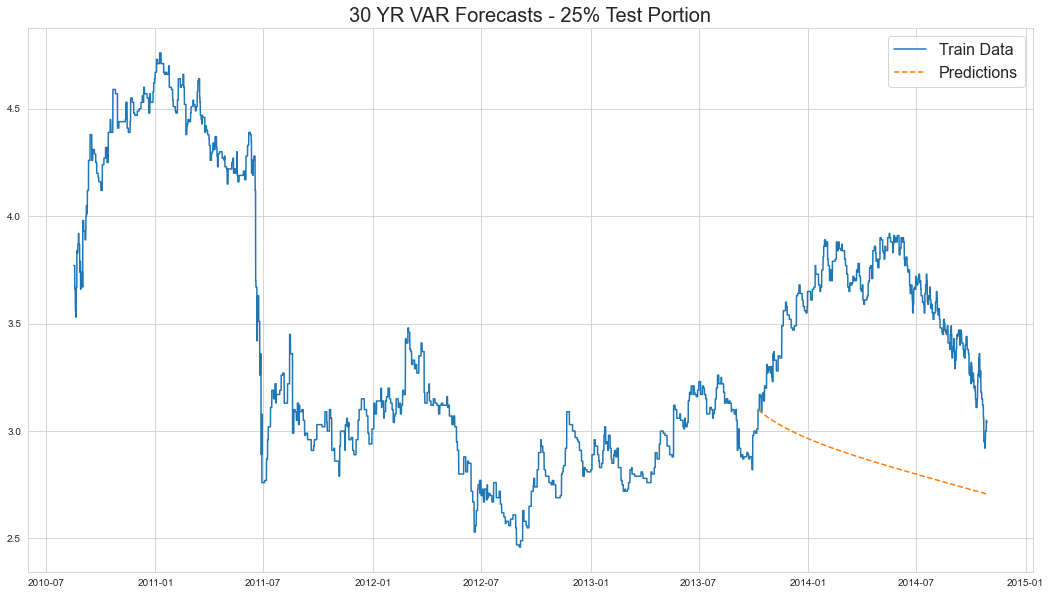

In [184]:
# Even with First Differencing, VAR model struggles to male accurate predictions
# Analogous to prediuction of the mean from statsmodels plot forecast method

# Plot for test length

plt.figure(figsize=(18,10))
plt.plot(df['30 YR'])
# plt.plot(train_preds,linestyle='dashed')
plt.plot(forecastvar_dftest1['30YR_forecast'],linestyle='dashed');
# plt.plot(y_test);
plt.title('30 YR VAR Forecasts - 25% Test Portion',size=20)
plt.legend(['Train Data','Predictions','Test Data'],prop={'size':16});

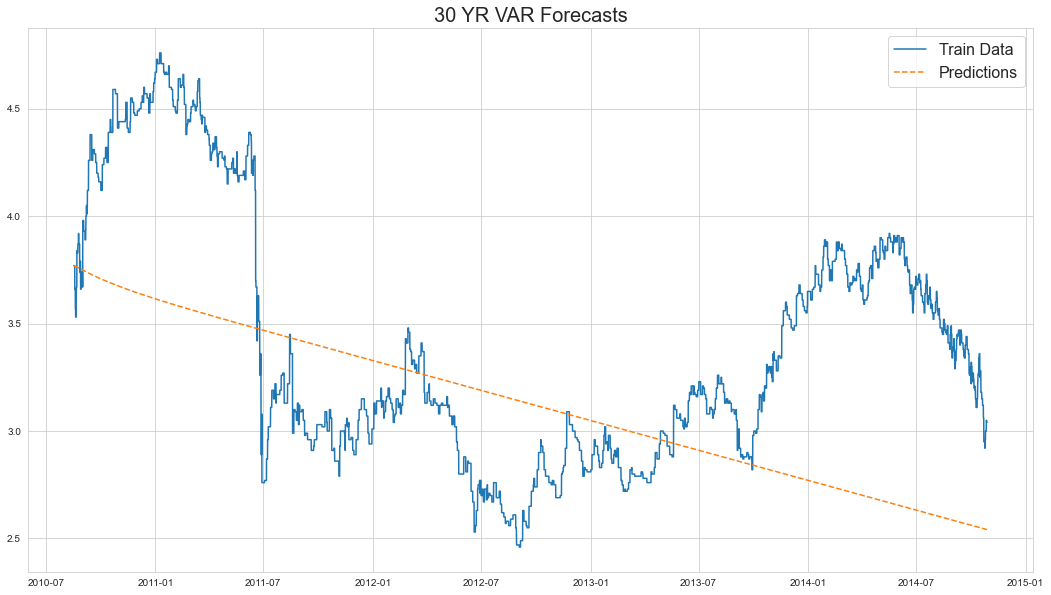

In [185]:
# plot for entire length

plt.figure(figsize=(18,10))
plt.plot(df['30 YR'])
# plt.plot(train_preds,linestyle='dashed')
plt.plot(forecastvar_df['30YR_forecast'],linestyle='dashed');
# plt.plot(y_test);
plt.title('30 YR VAR Forecasts',size=20)
plt.legend(['Train Data','Predictions','Test Data'],prop={'size':16});

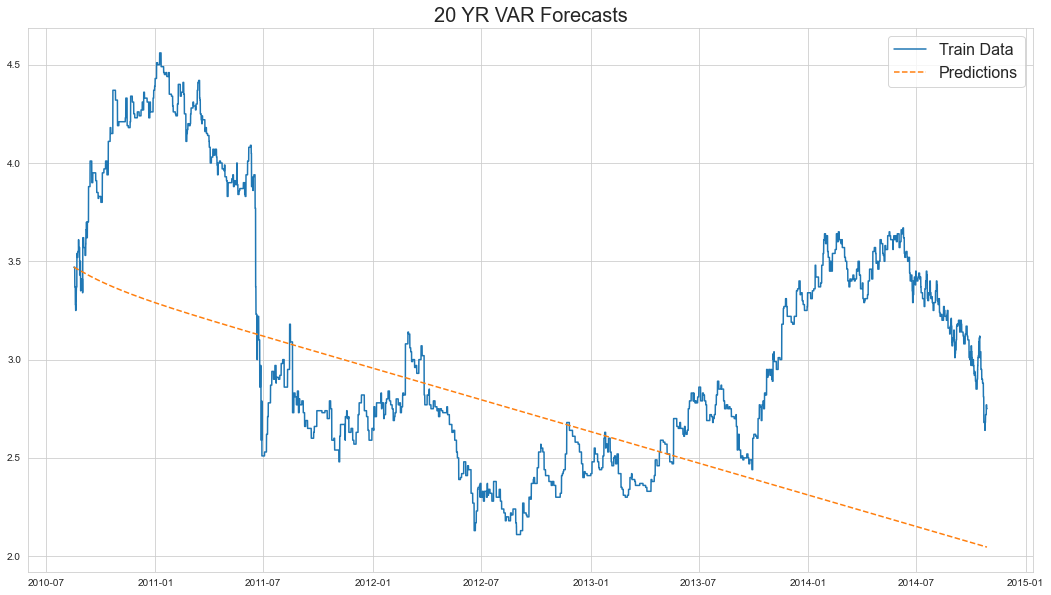

In [186]:
# plot for entire length

plt.figure(figsize=(18,10))
plt.plot(df['20 YR'])
# plt.plot(train_preds,linestyle='dashed')
plt.plot(forecastvar_df['20YR_forecast'],linestyle='dashed');
# plt.plot(y_test);
plt.title('20 YR VAR Forecasts',size=20)
plt.legend(['Train Data','Predictions','Test Data'],prop={'size':16});

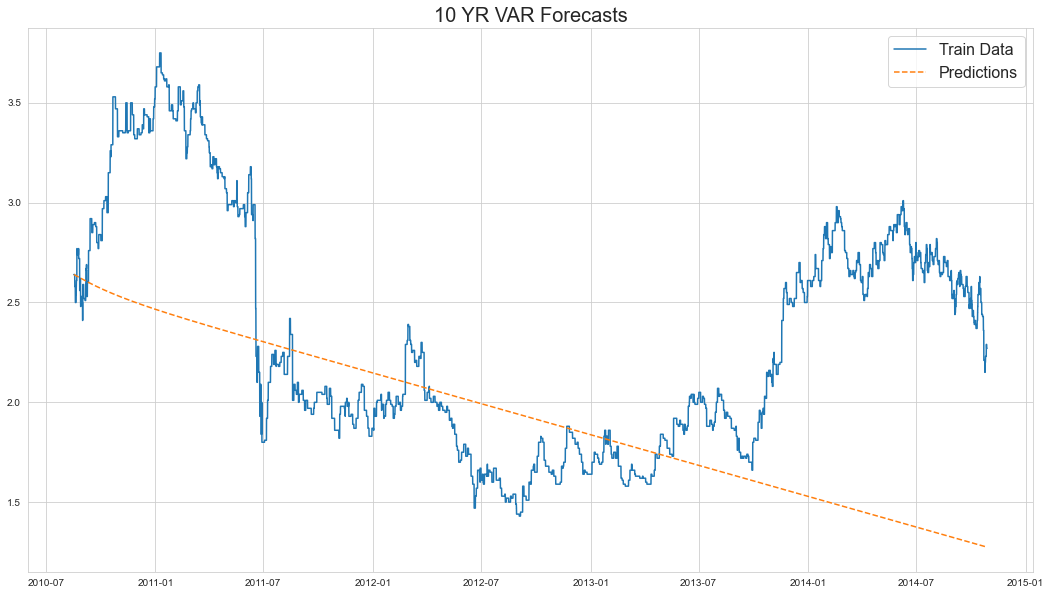

In [187]:
# plot for entire length

plt.figure(figsize=(18,10))
plt.plot(df['10 YR'])
# plt.plot(train_preds,linestyle='dashed')
plt.plot(forecastvar_df['10YR_forecast'],linestyle='dashed');
# plt.plot(y_test);
plt.title('10 YR VAR Forecasts',size=20)
plt.legend(['Train Data','Predictions','Test Data'],prop={'size':16});

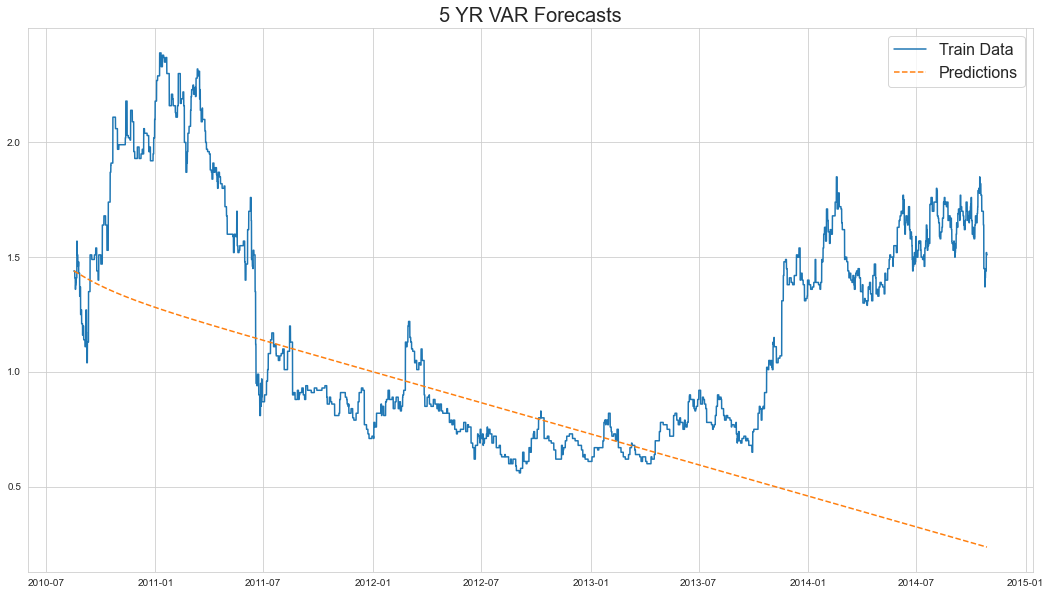

In [188]:
# plot for entire length

plt.figure(figsize=(18,10))
plt.plot(df['5 YR'])
# plt.plot(train_preds,linestyle='dashed')
plt.plot(forecastvar_df['5YR_forecast'],linestyle='dashed');
# plt.plot(y_test);
plt.title('5 YR VAR Forecasts',size=20)
plt.legend(['Train Data','Predictions','Test Data'],prop={'size':16});

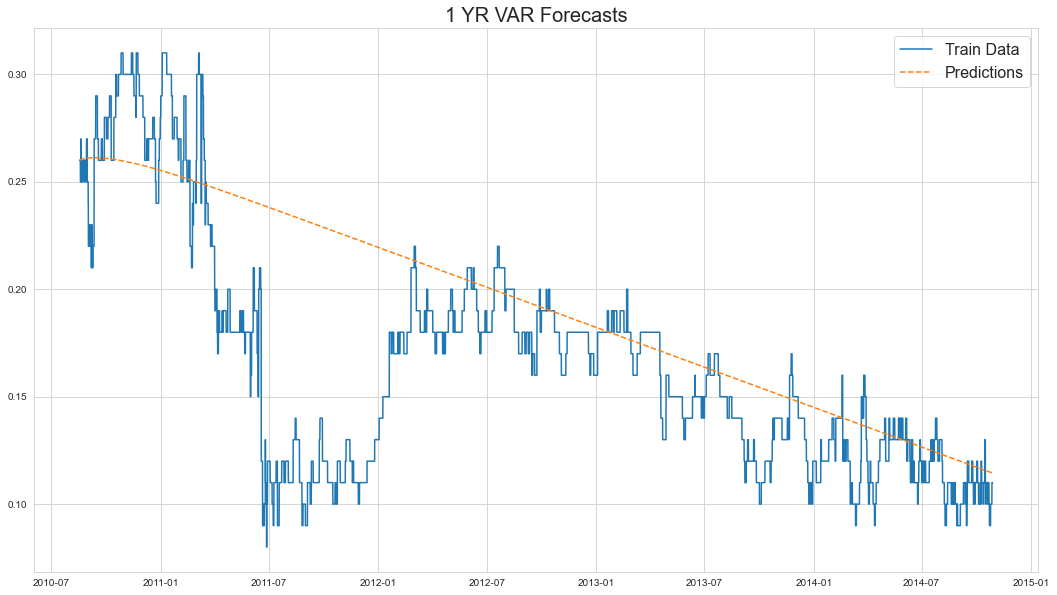

In [189]:
# plot for entire length

plt.figure(figsize=(18,10))
plt.plot(df['1 YR'])
# plt.plot(train_preds,linestyle='dashed')
plt.plot(forecastvar_df['1YR_forecast'],linestyle='dashed');
# plt.plot(y_test);
plt.title('1 YR VAR Forecasts',size=20)
plt.legend(['Train Data','Predictions','Test Data'],prop={'size':16});

### Comparable Standalone Metrics for VAR Model:

In [190]:
mean_absolute_percentage_error(test,forecast_var_test)

104.36194234040495

In [191]:
mean_squared_error(test,forecast_var_test)

0.0006086341164222267